In [1]:
import os
import tarfile
import requests
import pandas as pd
from pathlib import Path
from typing import Optional, Dict
from pydantic import BaseModel, ConfigDict
import matplotlib.pyplot as plt
import seaborn as sns


class MovieDataset(BaseModel):
    """Class to handle downloading, extracting, and loading the CMU Movie Dataset.

    Attributes:
        base_url (str): URL for downloading the dataset.
        dataset_filename (str): Name of the dataset archive file.
        download_dir (Path): Directory where dataset will be downloaded.
        extracted_dir (Path): Directory where dataset will be extracted.
        dataset_path (Path): Full path to the downloaded archive.
        dataframes (Dict[str, Optional[pd.DataFrame]]): Dictionary holding all loaded DataFrames.
    """

    base_url: str = "http://www.cs.cmu.edu/~ark/personas/data/"
    dataset_filename: str = "MovieSummaries.tar.gz"
    download_dir: Path = Path("downloads")
    extracted_dir: Path = download_dir / "MovieSummaries"
    dataset_path: Path = download_dir / dataset_filename

    # Dictionary to store all dynamically loaded datasets
    dataframes: Dict[str, Optional[pd.DataFrame]] = {}

    model_config = ConfigDict(arbitrary_types_allowed=True, extra="allow") 

    column_names: object = {
        "movie_metadata": [
            "wiki_movie_id", "freebase_movie_id", "movie_name", "release_date",
            "box_office_revenue", "runtime", "languages", "countries", "genres"
        ],
        "character_metadata": [
            "wiki_movie_id", "freebase_movie_id", "release_date", "character_name",
            "actor_dob", "actor_gender", "actor_height", "actor_ethnicity",
            "actor_name", "actor_age_at_release", "freebase_char_actor_map_id",
            "freebase_char_id", "freebase_actor_id"
        ],
        "plot_summaries": ["wiki_movie_id", "plot_summary"],
        "tvtropes_clusters": ["freebase_char_actor_map_id", "tvtrope_cluster"],
        "name_clusters": ["freebase_char_actor_map_id", "character_name"]
    }

    def __init__(self):
        """
        Initializes the MovieDataset class.
        - Creates necessary directories.
        - Downloads dataset if missing.
        - Extracts dataset if needed.
        - Dynamically loads all .tsv and .txt files into Pandas DataFrames.
        """

        super().__init__()

        # Ensure the download directory exists
        self.download_dir.mkdir(exist_ok=True)

        # Download dataset if it does not exist
        if not self.dataset_path.exists():
            self.download_dataset()

        # Extract dataset if it has not been extracted
        if not self.extracted_dir.exists():
            self.extract_dataset()

        # Load all available dataset files dynamically
        self.load_all_datasets()

    def download_dataset(self):
        """Downloads the dataset from the specified URL if it does not already exist."""
        print(f"Downloading {self.dataset_filename}...")

        try:
            response = requests.get(self.base_url + self.dataset_filename, stream=True)
            response.raise_for_status()

            with open(self.dataset_path, "wb") as file:
                for chunk in response.iter_content(chunk_size=8192):
                    file.write(chunk)

            print("Download complete.")

        except requests.exceptions.RequestException as e:
            print(f"Download failed: {e}")

    def extract_dataset(self):
        """Extracts the dataset archive into the designated directory."""
        print("Extracting dataset...")

        try:
            with tarfile.open(self.dataset_path, "r:gz") as tar:
                tar.extractall(path=self.download_dir)
            print("Extraction complete.")
        except tarfile.TarError as e:
            print(f"Error extracting dataset: {e}")

    def load_all_datasets(self):
        """
        Dynamically loads all .tsv and .txt files from the extracted directory into Pandas DataFrames.
        - Each dataset is stored in a dictionary (dataframes) using the filename (without extension) as the key.
        """

        if not self.extracted_dir.exists():
            print(f"Error: Extracted directory {self.extracted_dir} does not exist.")
            return

        for file_path in self.extracted_dir.glob("*"):
            if file_path.suffix in [".tsv", ".txt"]:  # Load only relevant file types
                self.load_dataset(file_path, sep="\t")
        
    def load_dataset(self, file_path: Path, sep: str = "\t"):
        """
        Loads a dataset file into a Pandas DataFrame and stores it in dataframes.

        Args:
            file_path (Path): Path to the dataset file.
            sep (str): Separator used in the file (default is tab-separated).
        """
        dataset_name = file_path.stem.replace('.', '_') # Extract filename without extension

        print(f"Checking file: {file_path}")  # Debugging line

        try:
            df = pd.read_csv(file_path, sep="\t", header=None)

            # Apply column names if recognized
            if dataset_name in self.column_names:
                df.columns = self.column_names[dataset_name]

            setattr(self, dataset_name, df)  # Dynamically set as attribute
            print(f"Loaded dataset: {dataset_name}, Shape: {df.shape}")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            setattr(self, dataset_name, None)
    
    def movie_type(self, N: int = 10) -> pd.DataFrame:
        """
        Returns a DataFrame with the N most common movie types (genres) and their counts.
        """
        if not isinstance(N, int):
            raise Exception("N must be an integer.")
        
        if not hasattr(self, "movie_metadata") or self.movie_metadata is None:
            raise Exception("Movie metadata is not loaded.")
        
        # Extract genres from the last column, which is a dictionary
        genre_series = self.movie_metadata["genres"].dropna()
        
        # Convert each genre dictionary into a list of genres and flatten
        genre_list = genre_series.apply(lambda x: list(eval(x).values()))  # Assuming it's stored as a stringified dictionary
        genre_flattened = [genre for sublist in genre_list for genre in sublist]

        # Count the occurrence of each genre
        genre_counts = pd.Series(genre_flattened).value_counts()
        
        # Create DataFrame with the top N genres
        result_df = genre_counts.head(N).reset_index()
        result_df.columns = ["Movie_Type", "Count"]
        
        return result_df

    def actor_count(self) -> pd.DataFrame:
        """
        Returns a histogram DataFrame showing the number of actors per movie vs. the movie count.
        Also, displays a histogram plot.
        
        The output DataFrame will have:
        - "Number_of_Actors" (unique actor count per movie)
        - "Movie_Count" (number of movies with that many actors)
        """
        if not hasattr(self, "character_metadata") or self.character_metadata is None:
            raise Exception("Character metadata is not loaded.")

        # Ensure required columns exist
        required_columns = {"wiki_movie_id", "actor_name"}
        if not required_columns.issubset(self.character_metadata.columns):
            raise Exception(f"Missing required columns: {required_columns - set(self.character_metadata.columns)}")

        # Count the number of unique actors per movie
        actor_counts = self.character_metadata.groupby("wiki_movie_id")["actor_name"].nunique()

        # Create a histogram DataFrame: How many movies have X number of actors?
        histogram = actor_counts.value_counts().reset_index()
        histogram.columns = ["Number_of_Actors", "Movie_Count"]

        # Sort the results in ascending order of number of actors
        histogram = histogram.sort_values(by="Number_of_Actors")

        # --- PLOT THE HISTOGRAM ---
        plt.figure(figsize=(10, 6))
        plt.bar(histogram["Number_of_Actors"], histogram["Movie_Count"], color="skyblue", edgecolor="black")
        plt.xlabel("Number of Actors per Movie")
        plt.ylabel("Movie Count")
        plt.title("Histogram of Number of Actors per Movie")
        plt.xticks(rotation=45)
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        
        # Show the plot
        plt.show()

        return histogram

    def actor_distributions(self, gender: str, max_height: float, min_height: float, plot: bool = False) -> pd.DataFrame:
        """
        Filters actor data based on gender and height range, and optionally plots the height distribution.

        Args:
            gender (str): "All" or a specific gender from the dataset.
            max_height (float): Maximum height threshold.
            min_height (float): Minimum height threshold.
            plot (bool, optional): If True, plots a histogram or density plot. Default is False.

        Returns:
            pd.DataFrame: Filtered actor dataset.
        """

        # Ensure valid input types
        if not isinstance(gender, str):
            raise Exception("Gender must be a string.")
        if not isinstance(max_height, (int, float)) or not isinstance(min_height, (int, float)):
            raise Exception("Height limits must be numerical values.")

        # Ensure the dataset is loaded
        if not hasattr(self, "character_metadata") or self.character_metadata is None:
            raise Exception("Character metadata is not loaded.")

        # Ensure required columns exist
        required_columns = {"actor_gender", "actor_height"}
        if not required_columns.issubset(self.character_metadata.columns):
            raise Exception(f"Missing required columns: {required_columns - set(self.character_metadata.columns)}")

        # Convert heights to numerical, forcing errors to NaN
        self.character_metadata["actor_height"] = pd.to_numeric(self.character_metadata["actor_height"], errors="coerce")

        # Drop missing height values
        df = self.character_metadata.dropna(subset=["actor_height"]).copy()

        # Standardize height units: Convert values > 10 (likely in cm) to meters
        df.loc[df["actor_height"] > 10, "actor_height"] /= 100

        # Apply gender filter
        valid_genders = df["actor_gender"].dropna().unique().tolist() + ["All"]
        if gender != "All":
            if gender not in valid_genders:
                raise Exception(f"Invalid gender value. Must be one of: {valid_genders}")
            df = df[df["actor_gender"] == gender]

        # Apply height range filter
        df = df[(df["actor_height"] >= min_height) & (df["actor_height"] <= max_height)]

        # If plot is True, create a density plot
        if plot:
            plt.figure(figsize=(10, 6))
            
            sns.kdeplot(df["actor_height"], color="blue", alpha=0.5)
            plt.ylabel("Density")
            plt.title(f"Density Plot of Actor Heights ({gender})")
            
            plt.xlabel("Actor Height (m)")
            plt.grid(axis="y", linestyle="--", alpha=0.7)
            plt.show()

        return df


In [2]:
import pytest

def test_movie_type():
    dataset = MovieDataset()
    with pytest.raises(Exception):
        dataset.movie_type("ten")
    result = dataset.movie_type(10)
    assert isinstance(result, pd.DataFrame)
    assert 'Movie_Type' in result.columns
    assert 'Count' in result.columns

def test_actor_count():
    dataset = MovieDataset()
    result = dataset.actor_count()
    assert isinstance(result, pd.DataFrame)
    assert 'Number_of_Actors' in result.columns
    assert 'Movie_Count' in result.columns

def test_actor_distributions():
    dataset = MovieDataset()
    with pytest.raises(Exception):
        dataset.actor_distributions(123, 180, 160)
    with pytest.raises(Exception):
        dataset.actor_distributions("Male", "tall", 160)
    with pytest.raises(Exception):
        dataset.actor_distributions("Male", 180, "short")
    result = dataset.actor_distributions("All", 180, 160)
    assert isinstance(result, pd.DataFrame)

In [45]:
test_data = MovieDataset()


Checking file: downloads/MovieSummaries/plot_summaries.txt
Loaded dataset: plot_summaries, Shape: (42303, 2)
Checking file: downloads/MovieSummaries/movie.metadata.tsv
Loaded dataset: movie_metadata, Shape: (81741, 9)
Checking file: downloads/MovieSummaries/name.clusters.txt
Loaded dataset: name_clusters, Shape: (2666, 2)
Checking file: downloads/MovieSummaries/README.txt
Loaded dataset: README, Shape: (52, 1)
Checking file: downloads/MovieSummaries/character.metadata.tsv
Loaded dataset: character_metadata, Shape: (450669, 13)
Checking file: downloads/MovieSummaries/tvtropes.clusters.txt
Loaded dataset: tvtropes_clusters, Shape: (501, 2)


In [46]:
test_data.movie_metadata.head()

,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [47]:
test_data.movie_type(5)

,Movie_Type,Count
0,Drama,34007
1,Comedy,16349
2,Romance Film,10234
3,Black-and-white,9094
4,Action,8798


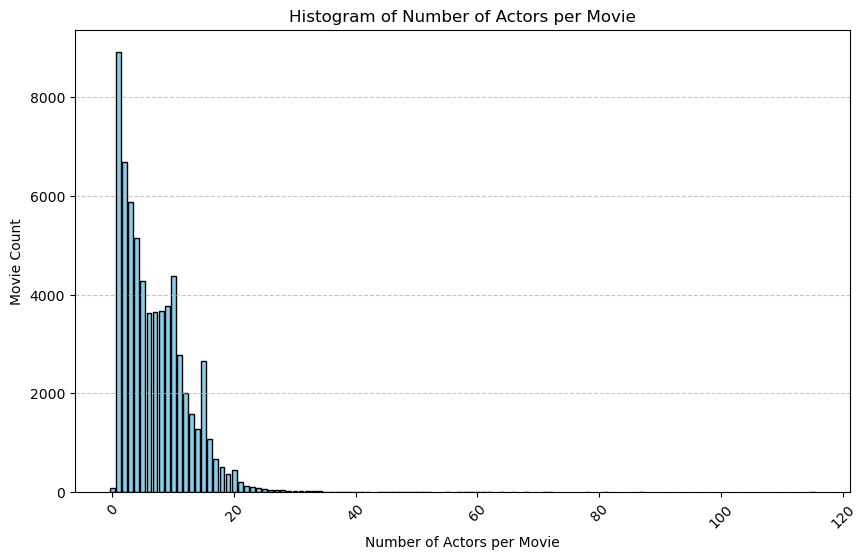

,Number_of_Actors,Movie_Count
24,0,72
0,1,8921
1,2,6699
2,3,5874
3,4,5159
...,...,...
57,72,1
53,78,1
60,81,1
52,87,1


In [48]:
test_data.actor_count()

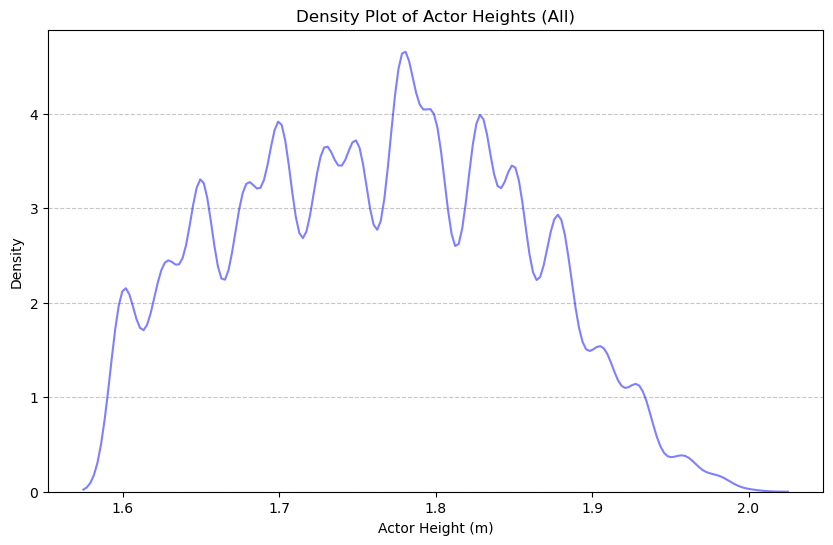

,wiki_movie_id,freebase_movie_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map_id,freebase_char_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450632,30553937,/m/0g9ts5h,1998-03-07,Troy,1970-06-22,M,1.910,NaN,Michael Trucco,27.0,/m/0gw24tv,/m/0jxtm_f,/m/08q6lr
450643,12476867,/m/02w7zz8,2002,NaN,1980-06-24,F,1.720,/m/041rx,Liane Balaban,21.0,/m/03jpb_5,NaN,/m/02pn4z4
450644,12476867,/m/02w7zz8,2002,NaN,1946-07-02,M,1.740,/m/041rx,Ron Silver,55.0,/m/04hv69s,NaN,/m/03swmf
450645,12476867,/m/02w7zz8,2002,NaN,1978,F,1.650,NaN,Siri Baruc,24.0,/m/0gc8cd7,NaN,/m/0gbwvjl


In [63]:
test_data.actor_distributions("All", 2.00, 1.60, plot=True)

In [50]:
test_data.character_metadata['actor_height']

0         1.620
1         1.780
2         1.727
3         1.750
4         1.650
          ...  
450664      NaN
450665      NaN
450666    1.730
450667      NaN
450668      NaN
Name: actor_height, Length: 450669, dtype: float64

In [52]:
test_data.character_metadata[test_data.character_metadata['actor_height'] > 1.8]

,wiki_movie_id,freebase_movie_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map_id,freebase_char_id,freebase_actor_id
8,975900,/m/03vyhn,2001-08-24,Michael Descanso,1971-03-20,M,1.892,NaN,Liam Waite,30.0,/m/03jqhb0,/m/0bgchs4,/m/0ks8b0
22,3196793,/m/08yl5d,2000-02-16,John Ramsey,1945-02-12,M,1.850,NaN,Cliff DeYoung,55.0,/m/0lr37f7,/m/0lr3z8x,/m/07jbhb
45,2238856,/m/06yc6v,2005-01,Andrew,1966-04-10,M,1.930,NaN,Brad William Henke,NaN,/m/0bf1hhc,/m/0g98drm,/m/02q288g
56,2314463,/m/0734w5,2006,Taper Guy,1971-05-26,M,1.870,/m/033tf_,Matt Stone,34.0,/m/0cgn0lx,/m/0h0z488,/m/01_x6d
74,18768079,/m/04gvb8t,1938-07-05,NaN,1901-04-05,M,1.860,/m/041rx,Melvyn Douglas,37.0,/m/04lrklr,NaN,/m/015gy7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450552,6456053,/m/0g605h,1964-12-31,Paolo Maltese,1927-10-18,M,1.850,/m/02ctzb,George C. Scott,37.0,/m/04p4q_p,/m/0hnw0l3,/m/0l786
450554,6456053,/m/0g605h,1964-12-31,NaN,1935-11-08,M,1.820,/m/03ts0c,Alain Delon,29.0,/m/0cs8fd1,NaN,/m/01syr4
450586,24997872,/m/09g6klx,2010-05-07,Surya,1982-10-16,M,1.810,/m/0dryh9k,Prithviraj Sukumaran,27.0,/m/0gw0rm2,/m/0gz549m,/m/0cqcgj
450601,32837210,/m/0h3pdgp,2011-09-22,NaN,1979-07-10,M,1.820,/m/01xhh5,Gong Yoo,32.0,/m/0h9fhpy,NaN,/m/02x9y8g


In [56]:
test_data.character_metadata['actor_gender'].value_counts()

actor_gender
M    270257
F    134803
Name: count, dtype: int64